In [1]:
import os
import time, datetime
import numpy as np
import pandas as pd
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt

### FUNCTIONS

In [2]:
def plot_win_percentage(df, col, label_col, target='won'):
    
    tmp1 = df[[col, target]].groupby([col, target]).size().reset_index(name='wins')
    tmp2 = pd.DataFrame({'win_pct' : tmp1.groupby([col])['wins'].apply(lambda x: round(x / x.sum(), 2))})
    tmp3 = pd.concat([tmp1, tmp2], axis=1)
    tmp3 = tmp3[tmp3[target] == 1]

    plt.figure(figsize=(8, 6), dpi=100)
    sns.lineplot(x=tmp3[col].astype(int), y=tmp3['win_pct'])
    plt.xlabel(label_col, fontsize=14)
    plt.ylabel('win percentage', fontsize=14)
    plt.title(f'{label_col} vs win percentage')
    #plt.savefig(os.path.join('OUTPUT_PATH', '{}_pct_win.png'.format(label_col)))
    plt.show()

### DATA

In [3]:
DATA_PATH = '../input/hkracing'

df_races = pd.read_csv(os.path.join(DATA_PATH, 'races.csv'))
df_runs = pd.read_csv(os.path.join(DATA_PATH, 'runs.csv'))

df_runners = pd.merge(df_races, df_runs, on='race_id', how='left')

### STATISTICS

In [4]:
print(f"Number of races : {df_runners.race_id.nunique()}")
print(f"Number of different horses : {df_runners.horse_id.nunique()}")
print(f"Number of different jockeys : {df_runners.jockey_id.nunique()}")
print(f"Number of different trainers : {df_runners.trainer_id.nunique()}")
print(f"Number of races' place : {df_runners.venue.nunique()}")
print(f"Data Period covered from {df_runners.date.min()} to {df_runners.date.max()}")
print(f"Number of different countries : {df_runners.horse_country.nunique()}")
print(f"Most dominant country : {df_runners.horse_country.mode()[0]}")
print(f"Most dominant horse type : {df_runners.horse_type.mode()[0]}")
print(f"Total high races run by a horse : {df_runners.horse_id.value_counts()[0]}")

Number of races : 6349
Number of different horses : 4405
Number of different jockeys : 186
Number of different trainers : 176
Number of races' place : 2
Data Period covered from 1997-06-02 to 2005-08-28
Number of different countries : 16
Most dominant country : AUS
Most dominant horse type : Gelding
Total high races run by a horse : 39


### MISSING VALUES

In [5]:
features_with_missing_values = df_runners.columns[df_runners.isna().sum(axis=0) > 0]
print(f"There is {len(features_with_missing_values)} features with missing values among the {df_runners.shape[1]} variables")

There is 51 features with missing values among the 73 variables


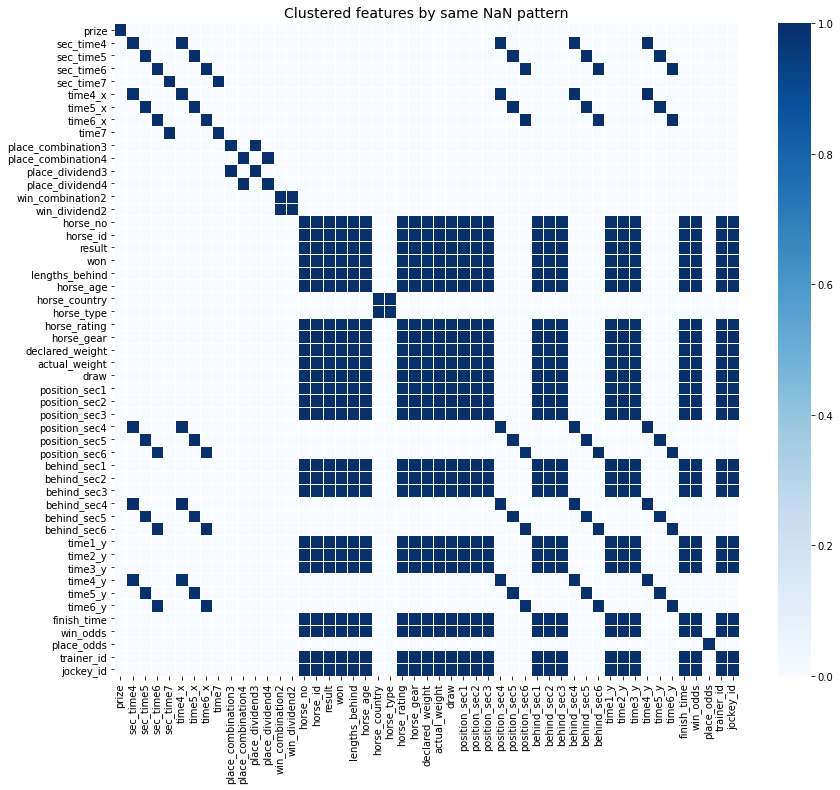

In [6]:
temp = df_runners[features_with_missing_values].isna()
temp = temp.astype(int).values

n = np.zeros((len(features_with_missing_values), len(features_with_missing_values)))
for i in (range(len(features_with_missing_values))):
    for j in range(len(features_with_missing_values)):
        n[i, j] = (temp[:, i]==temp[:, j]).all()

del temp

n  = pd.DataFrame(columns = features_with_missing_values, data=n, index= features_with_missing_values)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,12))
sns.heatmap(n, cmap='Blues', linewidths=.5,)
ax.set_title('Clustered features by same NaN pattern', fontsize=14)
plt.show()

- More than 90% of race date are missing 

### ADDITIONAL FEATURES

In [7]:
def is_place(result):
    return (result <= 3)*1

def compute_time_features(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['quarter'] = (df['month'] + 2)//3
    
    return df

def compute_race_features(df):  
    df['horse_under_4'] = df['horse_age'].apply(lambda a: 1 if a <= 4 else 0)
    df_runners_per_race = df[['race_id', 'horse_no']].groupby('race_id').size().reset_index(name='number_of_runners')
    df_runners_age = df[['race_id', 'horse_under_4']].groupby('race_id').sum().reset_index().rename(columns={'horse_under_4':'number_of_runners_under_4'})
    
    df = pd.merge(df, df_runners_per_race, on='race_id', how='left')
    df = pd.merge(df, df_runners_age, on='race_id', how='left')
    
    df['ratio_runners_under_4'] = df['number_of_runners_under_4'] / df['number_of_runners']
    del df_runners_per_race, df_runners_age
    
    return df


def compute_horse_features(df):   
    df = df.sort_values('date')  
    df['place'] = list(map(is_place, df['result']))
    df['last_place'] =   list(map(is_place, df.groupby('horse_id')['result'].shift()))
    df['last_draw'] = df.groupby('horse_id')['draw'].shift()    
    df['horse_rest_time'] = (df['date'] - df.groupby('horse_id')['date'].shift()).dt.days
    df['diff_declared_weight'] = df['declared_weight'] - df.groupby('horse_id')['declared_weight'].shift()
    df['diff_distance'] = df['distance'] - df.groupby('horse_id')['distance'].shift()  
    
    return df


def compute_owner_features(df, owner=None, group_col=None):
  
    """ function to compute statistics of the jockey and the trainer """  

    df_owner_runs = df[['race_id', f'{owner}_id']].groupby(f'{owner}_id').size().reset_index(name=f'{owner}_runs')
    df_owner_wins = df[df.won == 1][['race_id', f'{owner}_id']].groupby(f'{owner}_id').size().reset_index(name=f'{owner}_wins')
    df_owner_places = df[df.place == 1][['race_id', f'{owner}_id']].groupby(f'{owner}_id').size().reset_index(name=f'{owner}_places')

    dfs = [df, df_owner_runs, df_owner_wins, df_owner_places]
    df = reduce(lambda  left, right: pd.merge(left, right, on=[f'{owner}_id'], how='left'), dfs)  

    df[f'ratio_win_{owner}'] = df[f'{owner}_wins'] / df[f'{owner}_runs']
    df[f'ratio_place_{owner}'] = df[f'{owner}_places'] / df[f'{owner}_runs']

    del df_owner_runs, df_owner_wins, df_owner_places, dfs 
    
    if group_col:
        
        df_owner_group_runs = df[['race_id', f'{owner}_id', group_col]].groupby([f'{owner}_id', group_col]).size().reset_index(name=f'{owner}_{group_col}_runs')
        df_owner_group_wins = df[df.won == 1][['race_id', f'{owner}_id', group_col]].groupby([f'{owner}_id', group_col]).size().reset_index(name=f'{owner}_{group_col}_wins')
        df_owner_group_places = df[df.place == 1][['race_id', f'{owner}_id', group_col]].groupby([f'{owner}_id', group_col]).size().reset_index(name=f'{owner}_{group_col}_places')

        dfs_group = [df, df_owner_group_runs, df_owner_group_wins, df_owner_group_places]
        df = reduce(lambda  left,right: pd.merge(left,right,on=[f'{owner}_id'], how='left'), dfs_group)  

        df[f'ratio_win_{owner}_{group_col}'] = df[f'{owner}_{group_col}_wins'] / df[f'{owner}_{group_col}_runs']
        df[f'ratio_place_{owner}_{group_col}'] = df[f'{owner}_{group_col}_places'] / df[f'{owner}_{group_col}_runs']
        
        del df_owner_group_runs, df_owner_group_wins, df_owner_group_places, dfs
        
        
    return df

df_runners = compute_time_features(df_runners)
df_runners = compute_race_features(df_runners)
df_runners = compute_horse_features(df_runners)
df_runners = compute_owner_features(df_runners, owner='jockey')
df_runners = compute_owner_features(df_runners, owner='trainer')

### DATA DISTRIBUTION

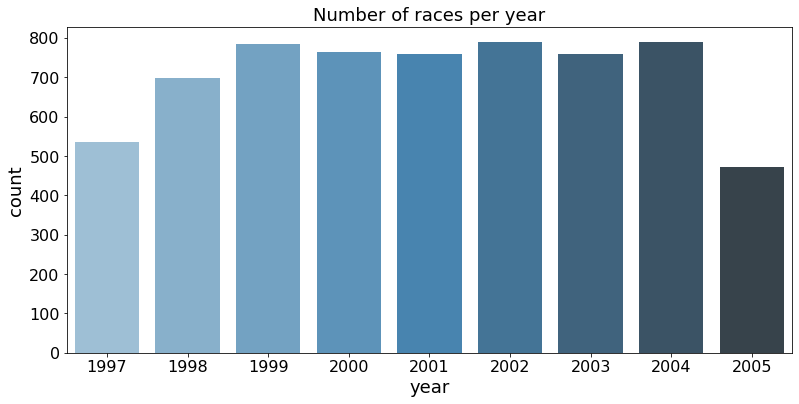

In [8]:
fig, ax = plt.subplots(figsize = (13, 6))
sns.countplot(x = df_runners.drop_duplicates(subset=['race_id', 'year'], keep='first')['year'], palette='Blues_d')
   
plt.title('Number of races per year', fontsize=18)
plt.xlabel('year', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16)
plt.savefig('year_distribution.png')
plt.show()

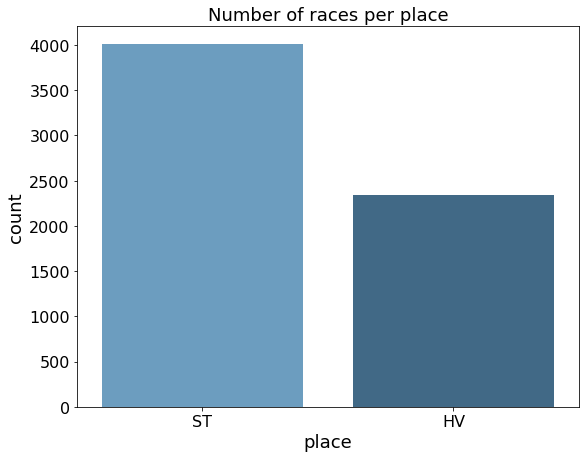

In [9]:
fig, ax = plt.subplots(figsize = (9, 7))
sns.countplot(x = df_runners.drop_duplicates(subset=['race_id', 'venue'], keep='first')['venue'], palette='Blues_d')
   
plt.title('Number of races per place', fontsize=18)
plt.xlabel('place', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16)
plt.savefig('hippo_distribution.png')
plt.show()

### TARGET DISTRIBUTION

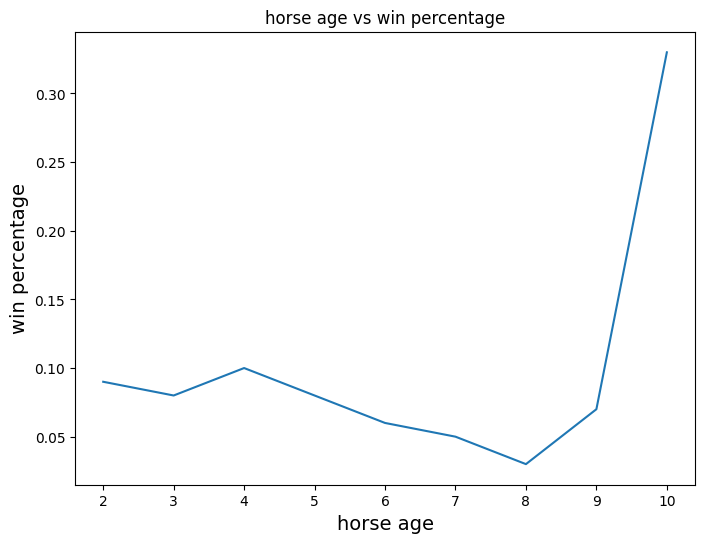

In [10]:
plot_win_percentage(df_runners, 'horse_age', 'horse age')

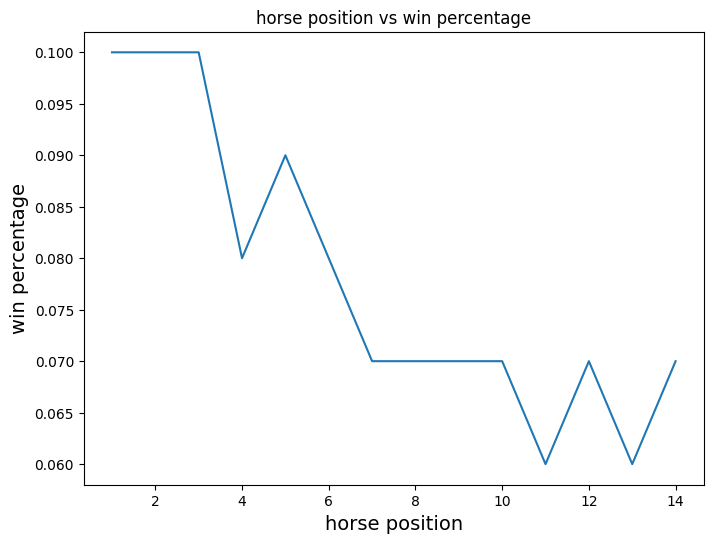

In [11]:
plot_win_percentage(df_runners, 'draw', 'horse position')

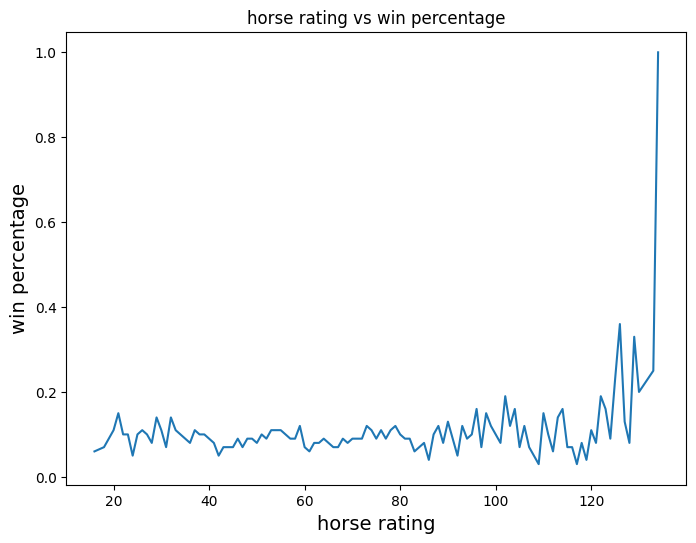

In [12]:
plot_win_percentage(df_runners, 'horse_rating', 'horse rating')

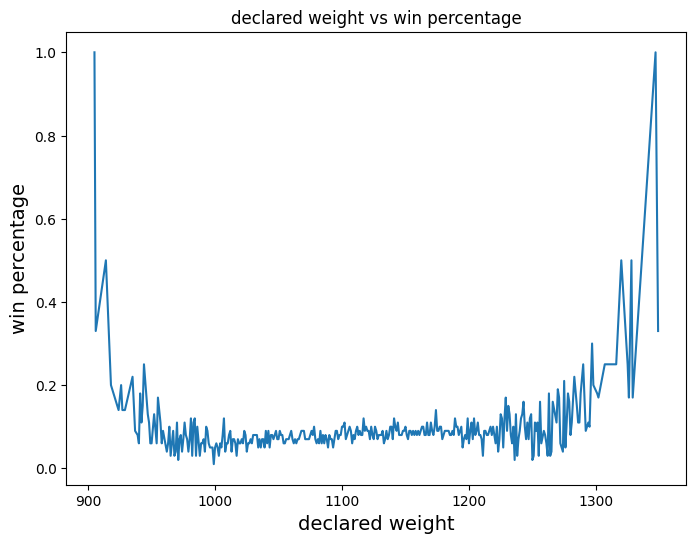

In [13]:
plot_win_percentage(df_runners, 'declared_weight', 'declared weight')

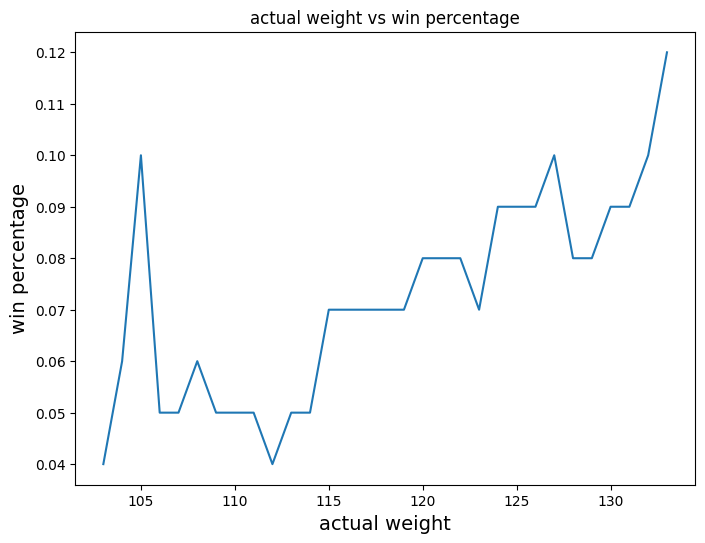

In [14]:
plot_win_percentage(df_runners, 'actual_weight', 'actual weight')

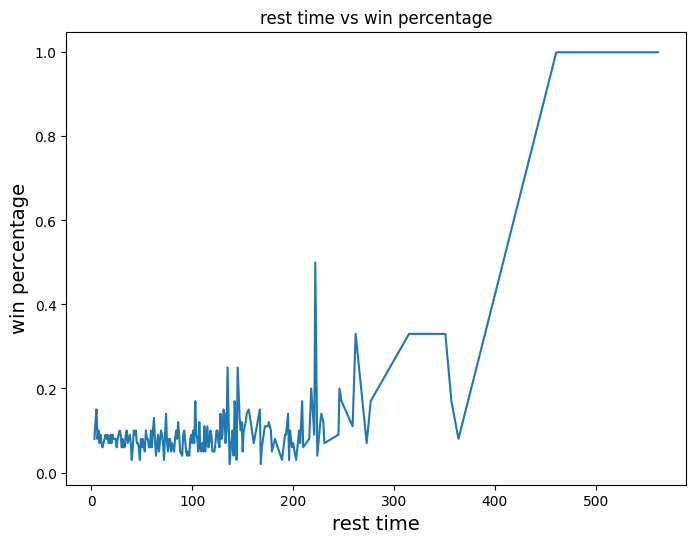

In [15]:
plot_win_percentage(df_runners, 'horse_rest_time', 'rest time')

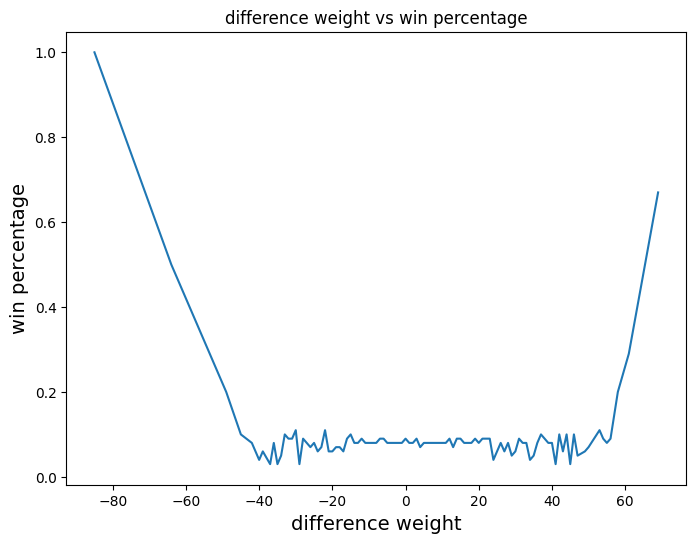

In [16]:
plot_win_percentage(df_runners, 'diff_declared_weight', 'difference weight')

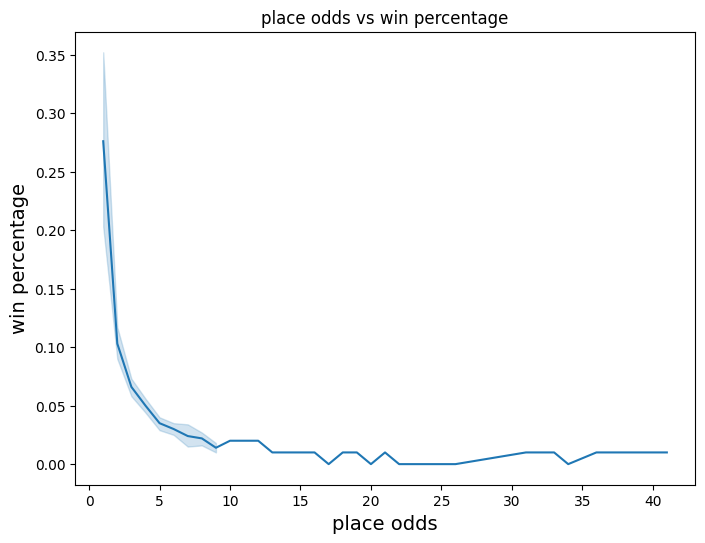

In [17]:
plot_win_percentage(df_runners, 'place_odds', 'place odds')

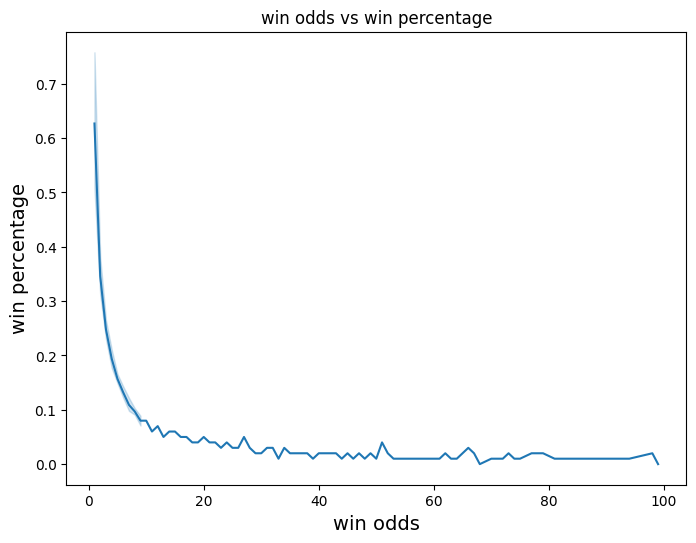

In [18]:
plot_win_percentage(df_runners, 'win_odds', 'win odds')

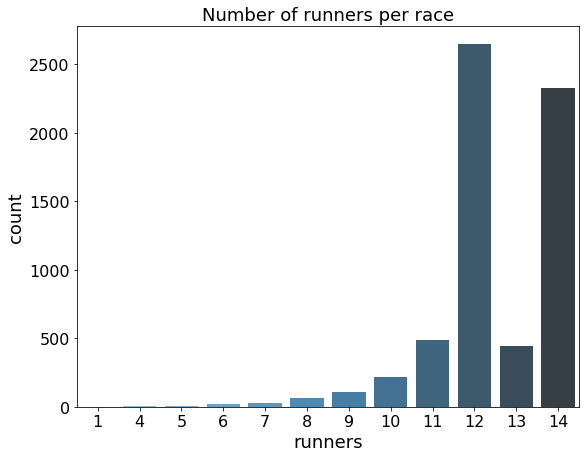

In [19]:
df_runners_per_race = df_runners[['race_id', 'horse_no']].groupby('race_id').size().reset_index(name='number_of_runners')

fig, ax = plt.subplots(figsize = (9, 7))
sns.countplot(x = df_runners_per_race['number_of_runners'], palette='Blues_d')
   
plt.title('Number of runners per race', fontsize=18)
plt.xlabel('runners', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16)
plt.show()

In [20]:
df_runners['number_of_runners'].value_counts(normalize=True)

14    0.409702
12    0.399356
13    0.072488
11    0.067982
10    0.027188
9     0.012348
8     0.006545
7     0.002467
6     0.001510
5     0.000252
4     0.000151
1     0.000013
Name: number_of_runners, dtype: float64

### TRAINER

In [21]:
df_runners[['race_id', 'trainer_id']].groupby('trainer_id').size().reset_index(name='trainer_runs').describe()

,trainer_id,trainer_runs
count,176.000000,176.000000
mean,87.500000,451.403409
std,50.950957,1138.320890
min,0.000000,1.000000
25%,43.750000,1.000000
50%,87.500000,2.000000
75%,131.250000,5.250000
max,175.000000,4739.000000


- 75% of trainers participate in less than 5 races

### JOCKEY

In [22]:
df_runners[['race_id', 'jockey_id']].groupby('jockey_id').size().reset_index(name='jockey_runs').describe()

,jockey_id,jockey_runs
count,186.000000,186.000000
mean,92.500000,427.134409
std,53.837719,935.997135
min,0.000000,1.000000
25%,46.250000,2.000000
50%,92.500000,10.500000
75%,138.750000,240.250000
max,185.000000,4719.000000


In [23]:
df_runners.head()

,race_id,date,venue,race_no,config,surface,distance,going,horse_ratings,prize,...,jockey_runs,jockey_wins,jockey_places,ratio_win_jockey,ratio_place_jockey,trainer_runs,trainer_wins,trainer_places,ratio_win_trainer,ratio_place_trainer
0,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0,...,4719.0,707.0,1811.0,0.149820,0.383768,3834.0,540.0,1369.0,0.140845,0.357068
1,7,1997-06-02,ST,8,A,0,1000,GOOD TO FIRM,100-80,1150000.0,...,1290.0,162.0,478.0,0.125581,0.370543,4109.0,504.0,1389.0,0.122658,0.338038
2,7,1997-06-02,ST,8,A,0,1000,GOOD TO FIRM,100-80,1150000.0,...,198.0,17.0,55.0,0.085859,0.277778,3834.0,540.0,1369.0,0.140845,0.357068
3,7,1997-06-02,ST,8,A,0,1000,GOOD TO FIRM,100-80,1150000.0,...,275.0,25.0,71.0,0.090909,0.258182,3167.0,267.0,835.0,0.084307,0.263656
4,7,1997-06-02,ST,8,A,0,1000,GOOD TO FIRM,100-80,1150000.0,...,3267.0,273.0,862.0,0.083563,0.263851,4600.0,466.0,1279.0,0.101304,0.278043
